# **Neural network training approach on the example of Logistic regression**

**Author**: Andrii Atoian

**Publication date**: 18/09/2022

**Email**: andrewatoyan@gmail.com

**Preface**

The purpose of this article is to show the background of the neural network training, using a familiar algorithm. In this case, we decided to choose the **logistic regression** - the algorithm, that allows us to solve the binary classification problem. This choice is justified by the following reasons:

- **sigmoid function** of the logistic regression is one of the possible activation functions used to  compress values inside the layers in some range ([0, 1] in the case of sigmoid). In the light of classifictaion problem it gives us propabilities of the event. In neural networks it is used to compress the information and pass it to the next layers.

- **cost function** of the logit model - the indicator, which shows us how well the model is trained in different phases (the lower - the better); The generalized verision of it is known as Cross-Entropy function, where the choise is not binomial. It is commonly used in neural networks, so it will be useful to explore the former version of it.


**Keywords:** Neural Networks, Computational Graph, Jacobian matrices product, Gradient Descent, Logistic Regression, Pytorch.

# Data loading & overview

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from matplotlib import pyplot as plt
from matplotlib import style

First of all, we need to load our data. In order to cover all the aspects described in the preface, a specific dataset has been created. It consists of 5 columns. Variables "x1", "x2", "y" are designed to the model evaluation, while the other two will be used in the theoretical block, dedicated to data scaling and its impact on parameter optimization.

In [ ]:
#import data in google colab; file: "datalog2.csv"
files.upload() 

#read it as a dataframe;
df = pd.read_csv("data_logit2.csv")
df.head(5)

Saving data_logit2.csv to data_logit2.csv


,x1,x2,y,bx_sd,bx_nr
0,89.946963,72.091781,1,2.980495,2.456069
1,77.111425,75.206589,1,1.937979,2.257133
2,71.854053,80.549965,1,1.770198,2.223228
3,67.182350,97.026782,1,2.368582,2.330291
4,71.087755,71.098405,1,1.093755,2.098622


Logistic regression is part of the GLM family algorithms. In it`s simplest representation it fits a straight line, which is then transformed in a well-known sigmoid curve that defines the probabilities of event. But it also capable to catch the non-linear patterns, by adding polynomals of initial featuread and/or their product. In this tutorial it is used as an excellent learning material regarding the neural network training approach.

#Theoretical block: Scale transformation methods

Despite the fact that our data is a little bit messy, where are going to **avoid the part of data processing**, which  is **individual** for every example.
But instead, we will concern the scale data transformations, that may help us to get to the global minimum in the more efficient way.

There are **two transformational techniques** that are commonly used for this purpose:

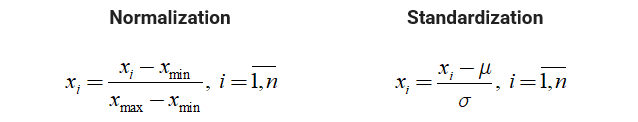

In order to make a choice in favor of a particular transformation, it is necessary to concern the structural elements of the model itself. Let`s examine the relationship between sigmoid and the cost function, using the computation graph below.

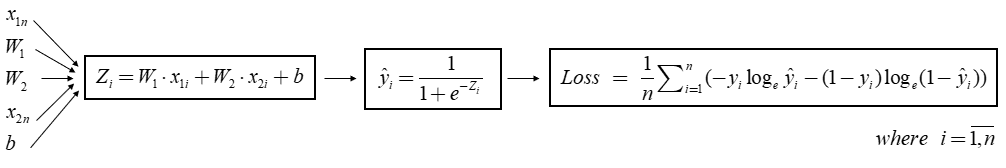

Binary classification assumes two possible values for the variable $y_i$. The loss equation is constructed in such a way that depending on what $y_{i}$ is (1 or 0), we get into the first or the second part of the equation, respectively. In both cases, we are dealing with a logarithm which is responsible for penalties. To avoid them, we want the final value of the argument to be close to one, because $\log_{e}{1} = 0$. Thus, the model estimates $\hat{y_i}$ should be as close as possible to the real values of $y_i$.

In turn, $\hat{y_i}$ is calculated using formula above. **This is where the answer to our question lies.**

If we apply normalization, then our values will be in the range of [0; 1]. By putting them in a sigmoid equation, we will be dealing with one half of the curve, since the $\sigma(0) = 0.5$. Even if further iterations change things a bit by updating the model coefficients, there is still a conceptual problem here: normalization is used for those features that have explicit boundaries. For example, image pixels that are commonly used in CNN models lie in the range [0; 255]. For such a case, normalization seems to be suitable. Whereas for our example, we cannot guarantee that the new data after the transformation will not exceed or lie below the given range.

At the same time, standardization itself does not imply the presence of any boundaries in the data. The original data will be transformed with respect to series characteristics like mean and standard deviation. Thus, the final series  will include both negative and positive values, which will ensure that the estimates are placed over the entire sigmoid.

In order to illustrate this in practice, we are going to use some series that have been prepared in advance. **"bx_sd"** and **"bx_mm"** are simply the estimates of the equation: 
$Z_{i} = \beta_{0} + \beta_{1} x_{1i} + \beta_{2} x_{2i}$ for both - standardized and normalized data, respectively. In this case, the set of initial weights is the most typical one: $\beta = [1, 1, 1]$. Note, that in the light of simplicity, the scale transformation methods were carried out for the entire series **"x1"** and **"x2"** without splitting them into training/test groups.

In [ ]:
def sigmoid_cust(x_f):
  return 1/(1 + np.exp(-x_f))

The only thing we need to do is define a sigmoid function to calculate the probabilities.

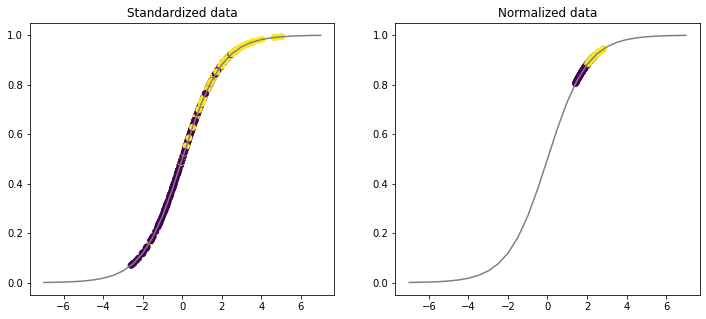

In [ ]:
bx_sd, bx_nr = df["bx_sd"].to_numpy(), df["bx_nr"].to_numpy()
y_np = df['y'].to_numpy()

#create some range to plot the sigmoid function;
x = np.arange(-7, 7.5, step = 0.5)

#define the grid to provide comparison the plot of Standardized and Normalized data;
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax1.scatter(bx_sd, sigmoid_cust(bx_sd), c=y_np)
ax1.plot(x, sigmoid_cust(x), "-", color="grey")
ax1.set_title('Standardized data')

ax2.scatter(bx_nr, sigmoid_cust(bx_nr), c=y_np)
ax2.plot(x, sigmoid_cust(x), "-", color="grey")
ax2.set_title('Normalized data')

plt.show()

As we can see, there is a huge difference between these types of transformation. The reason why the normalized data is slightly higher than 0.5 is due to the structure of the linear equation. But in general, the patterns are exactly the same as described above.

**But which type of scale transformation is the most appropriate?** 

To answer this question we have to keep in mind the relationship between sigmoid estimates $\hat{y_i}$ and the loss function. In the case of normalization, the penalties for True labels will be modest, since their estimates are quite close to the real ones. Whereas for the False labels, the situation is just the opposite: to minimize the penalties for $\log_{e}{(1-p)}$, we want the probability to be close to zero. This results in $\log_{e}{(1-0)} = \log_{e}{1} = 0$, which in turn means no penalties. Due to the fact that the data is compressed in a small range and mostly lies on the top of the sigmoid function, for this example, the loss estimates for the normalized data will be much higher compared to the standardized one. Thus, following the logic of the model`s conctruction, standardization is a more suitable type of transformation.

Before we end this issue, we also need to say a few words about **pure data**.  As you can see, closer to the edges, the sigmoid function resembles a straight horizontal line. This means that the difference becomes negligible for values lying far away from the bend. Thus, if we plug the raw data into a linear equation and convert the estimates to probabilities, we will get "1" in all cases. This can be changed by updating the weights.

But if we ask ourselves about **the best starting point for parameters optimization**, what would be the most reasonable choice?

Given the model`s construction and the data processing theory outlined above, standardization is an excellent tool that can significantly accelerate the process of convergence and prevent disproportionate steps during iteration. This, in turn, can reduce the training time as well as the computational cost.



# Practical implementation of data scaling

Having considered the main aspects of data transformation methods, we can finally put our knowledge into practice. To apply standardization, we need to extract the columns we mentioned at the beginning from the dataframe and convert them to numpy arrays.

In [ ]:
x_np = df[["x1", "x2"]].to_numpy()
y_np = df['y'].to_numpy()

We also divided our data into two groups: training and test sets. This will allow us to test the performance of the model later.

In [ ]:
#The proportion of training/test groups is 80/20 respectively.
x_train, x_test, y_train, y_test = train_test_split(x_np, y_np, test_size=0.2, random_state=120)

By applying standardization to the training set, we not only scale the series, but also preserve the key characteristics, like mean and standard deviation, for the "future". On their basis we could provide the forward or backward transformations. Thus, using the training test properties, we also scale our test group.

In [ ]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In this article, we will recreate the optimization process manually. The reason for this is that we want to show the background of the model's training, the mathematics behind it, in order to create not only an intuitive, but also a deep understanding of the underlying processes.

But before we start, we need to make some changes: add a column with constant value for both - **x_train** and **x_test** datasets.

In [ ]:
x_train = np.insert(x_train, 0, 1, axis=1)
x_test = np.insert(x_test, 0, 1, axis=1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In this article, we are mainly working with the pytorch framework. Thus, we need to convert numpy arrays to torch tensors in order to access its functionality.

In [ ]:
x_train_t = torch.from_numpy(x_train.astype(np.float32))
x_test_t = torch.from_numpy(x_test.astype(np.float32)) 
y_train_t = torch.from_numpy(y_train.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.float32))

#Theoretical block: Computational graph & Jacobian matrix 

Each algorithm has its own steps that we need to go through in order to achieve parameter optimization. Due to the fact that we are dealing with a huge number of parameters, it has become a little difficult to find the partial derivative of the loss function with respect to a specific weight. This is why, in the world of the neural networks, the phases of model calculus are represented by the **computational graph**, where each node corresponds to a specific mathematical operation. This approach eliminates such a problem and provides a deeper understanding of model training (forward and back propagations), simplifies the mathematics.

The big advantage is that we can apply the same technique to other algorithms with fewer parameters. In our case, we will illustrate this with the help of logistic regression. The computational graph of it is shown below:



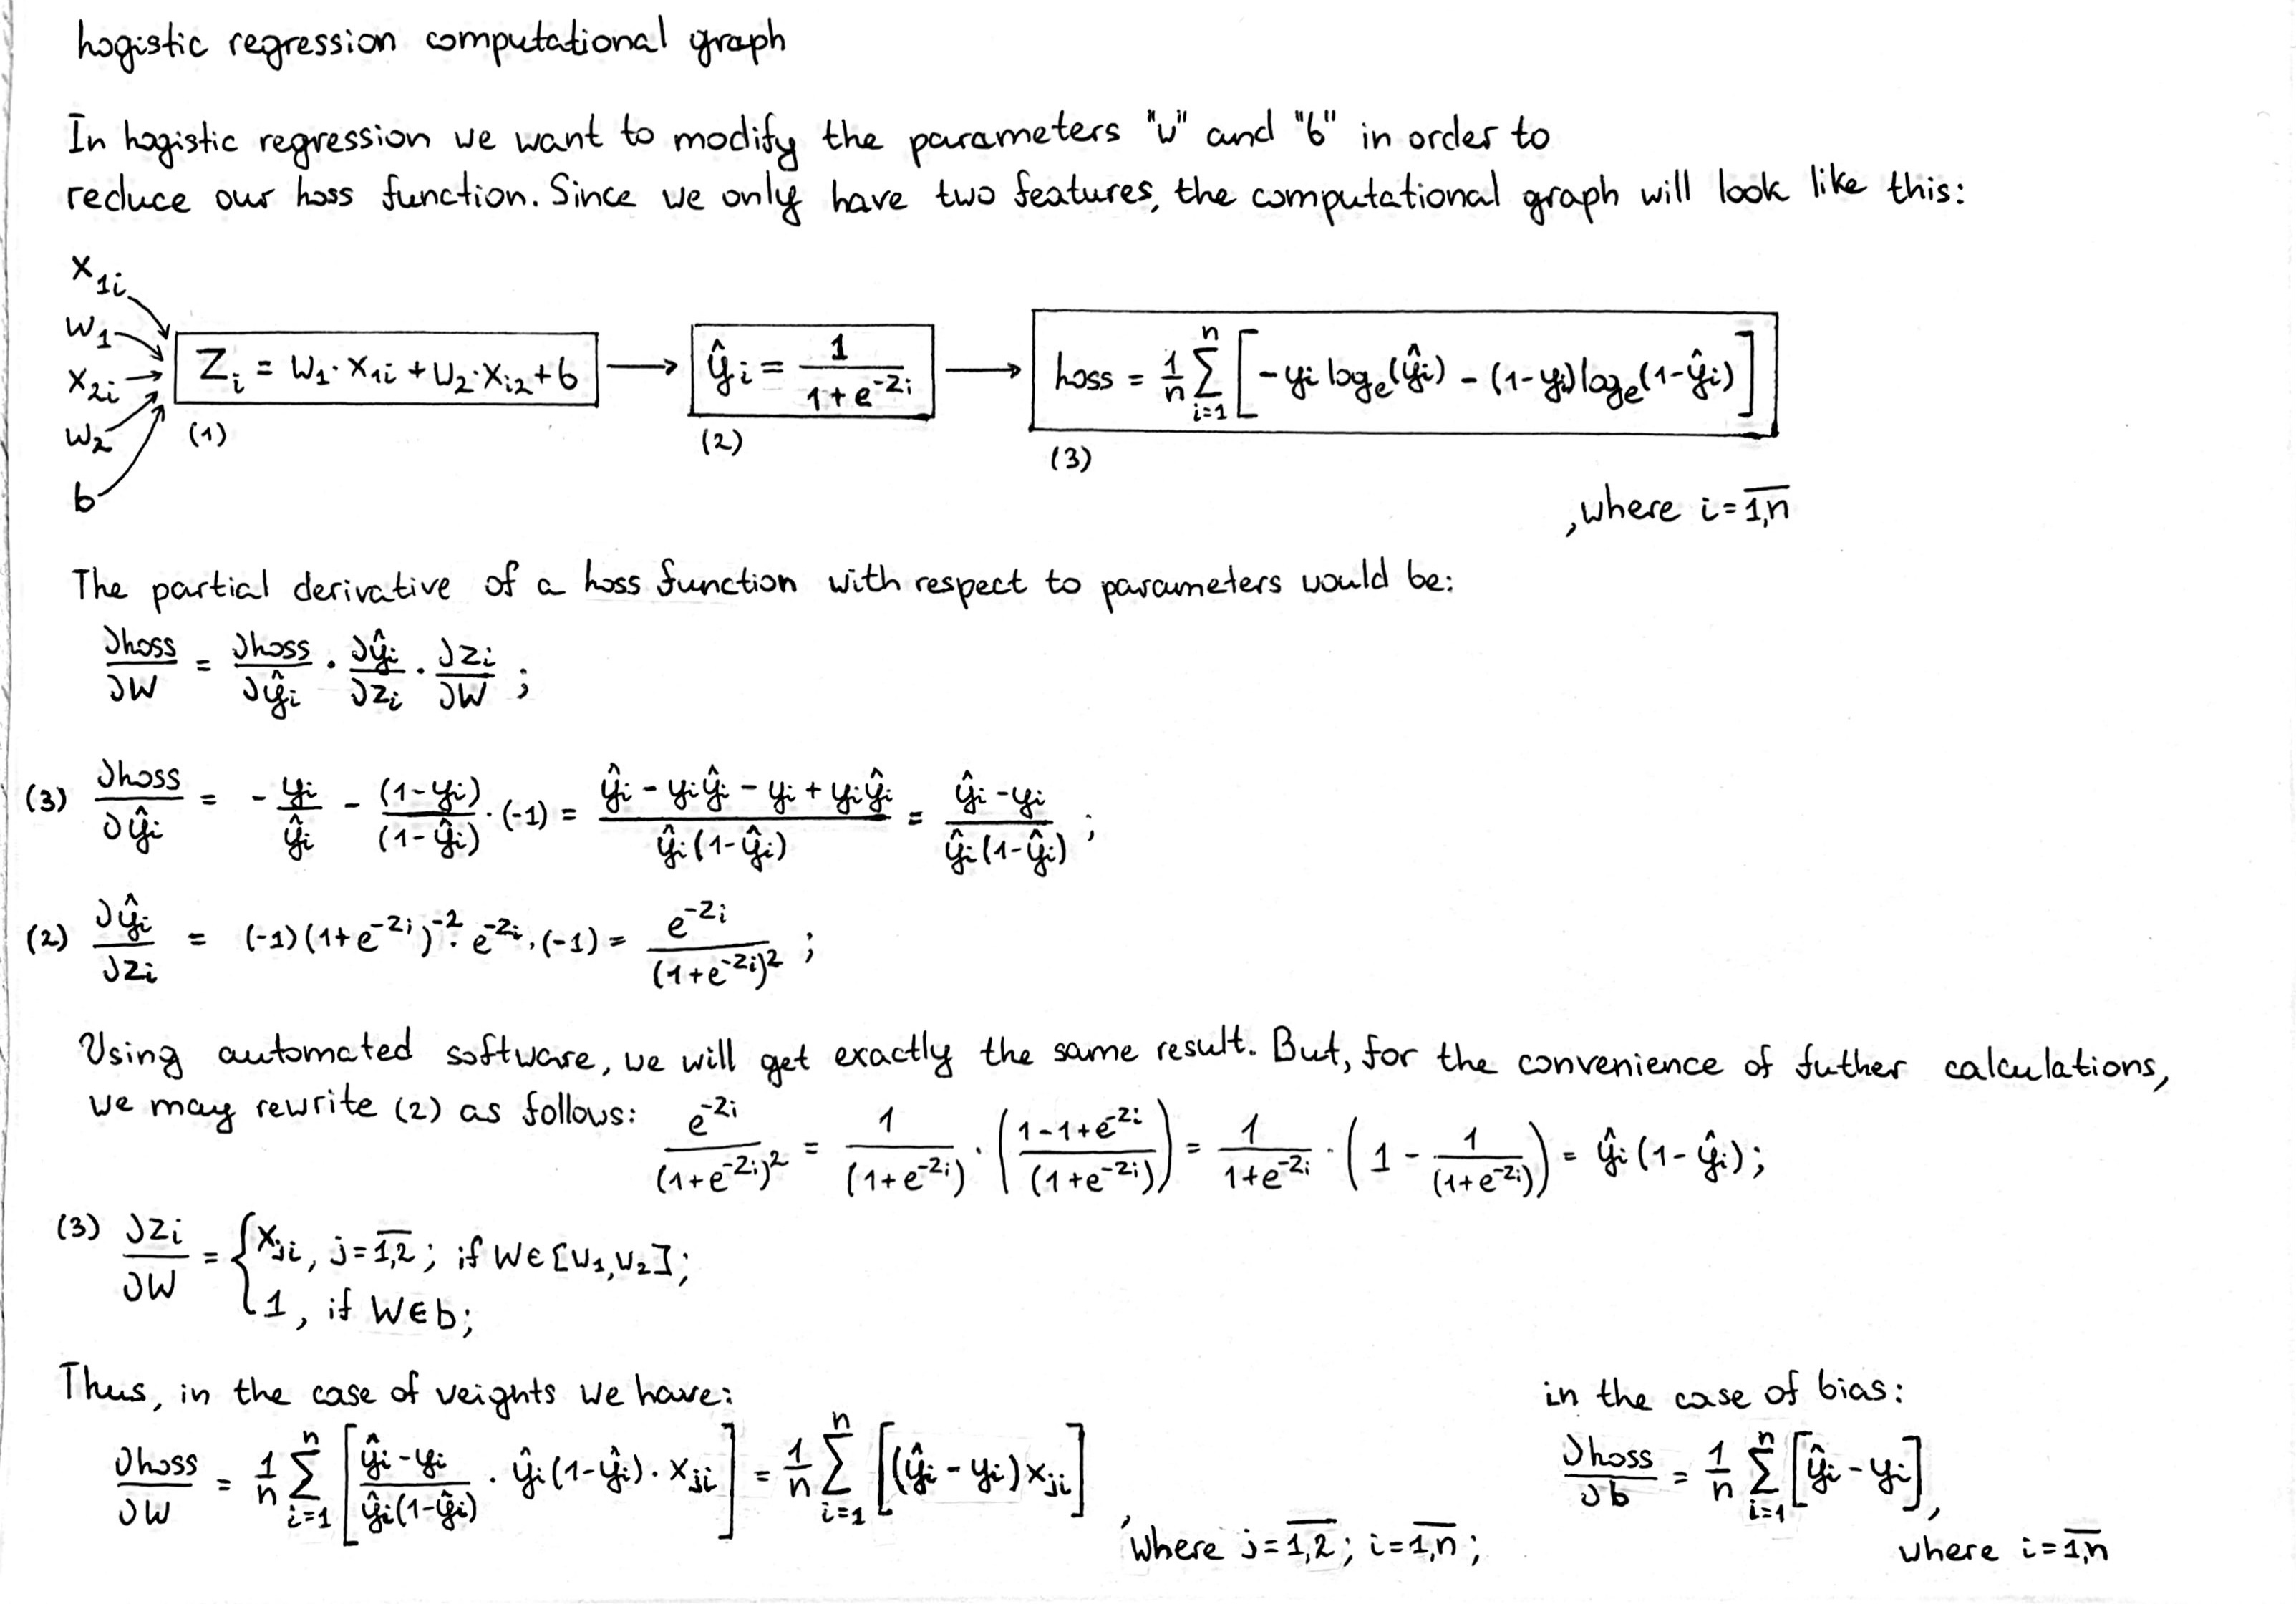

Model`s training consists of two steps:

*   **Forward propagation** refers to model estimation with respect to the stages represented by the graph. This allows us to collect and track the history of the model's performance.

*   **Back propagation** is responsible for obtaining the gradient that is used to adjust weights during iterations. In fact, it is nothing more than a chain rule in the opposite direction. The reason we computing gradients from the tail is that it allows us to avoid redundant calculations. Moving backwards, we compute derivatives for all the weights in one go. Whereas forward-mode differentiation implies finding the derivative with respect to a single parameter [11].

In the light of logistic regression, finding gradients does not seem to be complex. But everything changes when it comes to algorithms like neural networks, where we have to optimize an enormous number of parameters. Due to the peculiarities of their construction the same weight may affect the output in several ways. That is why such calculations were generalised and expressed by the **Jacobian matrices**.

Lets cover this approach on the example of the first node. In terms of mathematics, the equation $z_{1} = b_{0} + w_{1}x_{11}+ w_{2}x_{21}$ is called scale-valued function. It means that function $Z: R^{k} → R$ takes $k$ inputs and returns a scalar value, defined by the given equation. For a such case, the Jacobian matrix is a row vector $(1 \times k)$ containing all first-order partial derivatives:

\begin{align*}
\frac{\partial z_{1}}{\partial (b, w_{1}, w_{2})} = \bigg[  \frac{\partial z_{1} }{\partial b} \; \frac{\partial z_{1} }{\partial w_{1}} \; \frac{\partial z_{1} }{\partial w_{2}} \bigg]
\end{align*}

On practie we are quite often working with a vector-valued function, which can be considered as some generalization of the previous one. The difference lies in the form of the output which is now represented by a vector [22]. In other words, for a function of type $Z: R^{k}→ R^{m}$ we map $k$ inputs to multiple outputs $m$.

The first node equation $z_{i} = b_{0} + w_{1}x_{1i}+ w_{2}x_{2i}, \; i = \overline{1,n}$ falls under this definition. It produces $n$ outputs by taking $3$ parameters as input. In this case, the Jacobian will be a $(n \times 3)$ matrix consisting of patrial derivative vectors collected row-wise, where each row corresponds to a specific $z_{i}, \; i = \overline{1,n}$.

\begin{gather}
Z = 
\begin{bmatrix}
z_{1} \\
z_{2} \\
... \\
z_{n} \\
\end{bmatrix}
\hspace{1cm}
\frac{\partial (z_{1},..,z_{n})}{\partial (b, w_{1}, w_{2})} =
\begin{bmatrix}
\frac{\partial z_{1} }{\partial b} &  \frac{\partial z_{1} }{\partial w_{1}} &  \frac{\partial z_{1} }{\partial w_{2}} \\
\frac{\partial z_{2} }{\partial b} &  \frac{\partial z_{2} }{\partial w_{1}} &  \frac{\partial z_{2} }{\partial w_{2}} \\
& ... & \\
\frac{\partial z_{n} }{\partial b} &  \frac{\partial z_{n} }{\partial w_{1}} &  \frac{\partial z_{n} }{\partial w_{2}} \\
\end{bmatrix}
\end{gather}

In accordance with outlined theory we also may define the Jacobian for the rest of the nodes (see below). Storing the data this way allows us to significantly simplify the gradient finding process, which in fact, is reduced to the matrices product conducted in reverse order. Now, we can see how the shape of the matrices is redefined in the course of calculations. The resulting matrix $(n \times 3)$ is nothing more than a gradient - a vector of partial derivatives of the loss function with respect to the model parameters. These magnitudes are 
 used to incrementally update the weights during iteration.

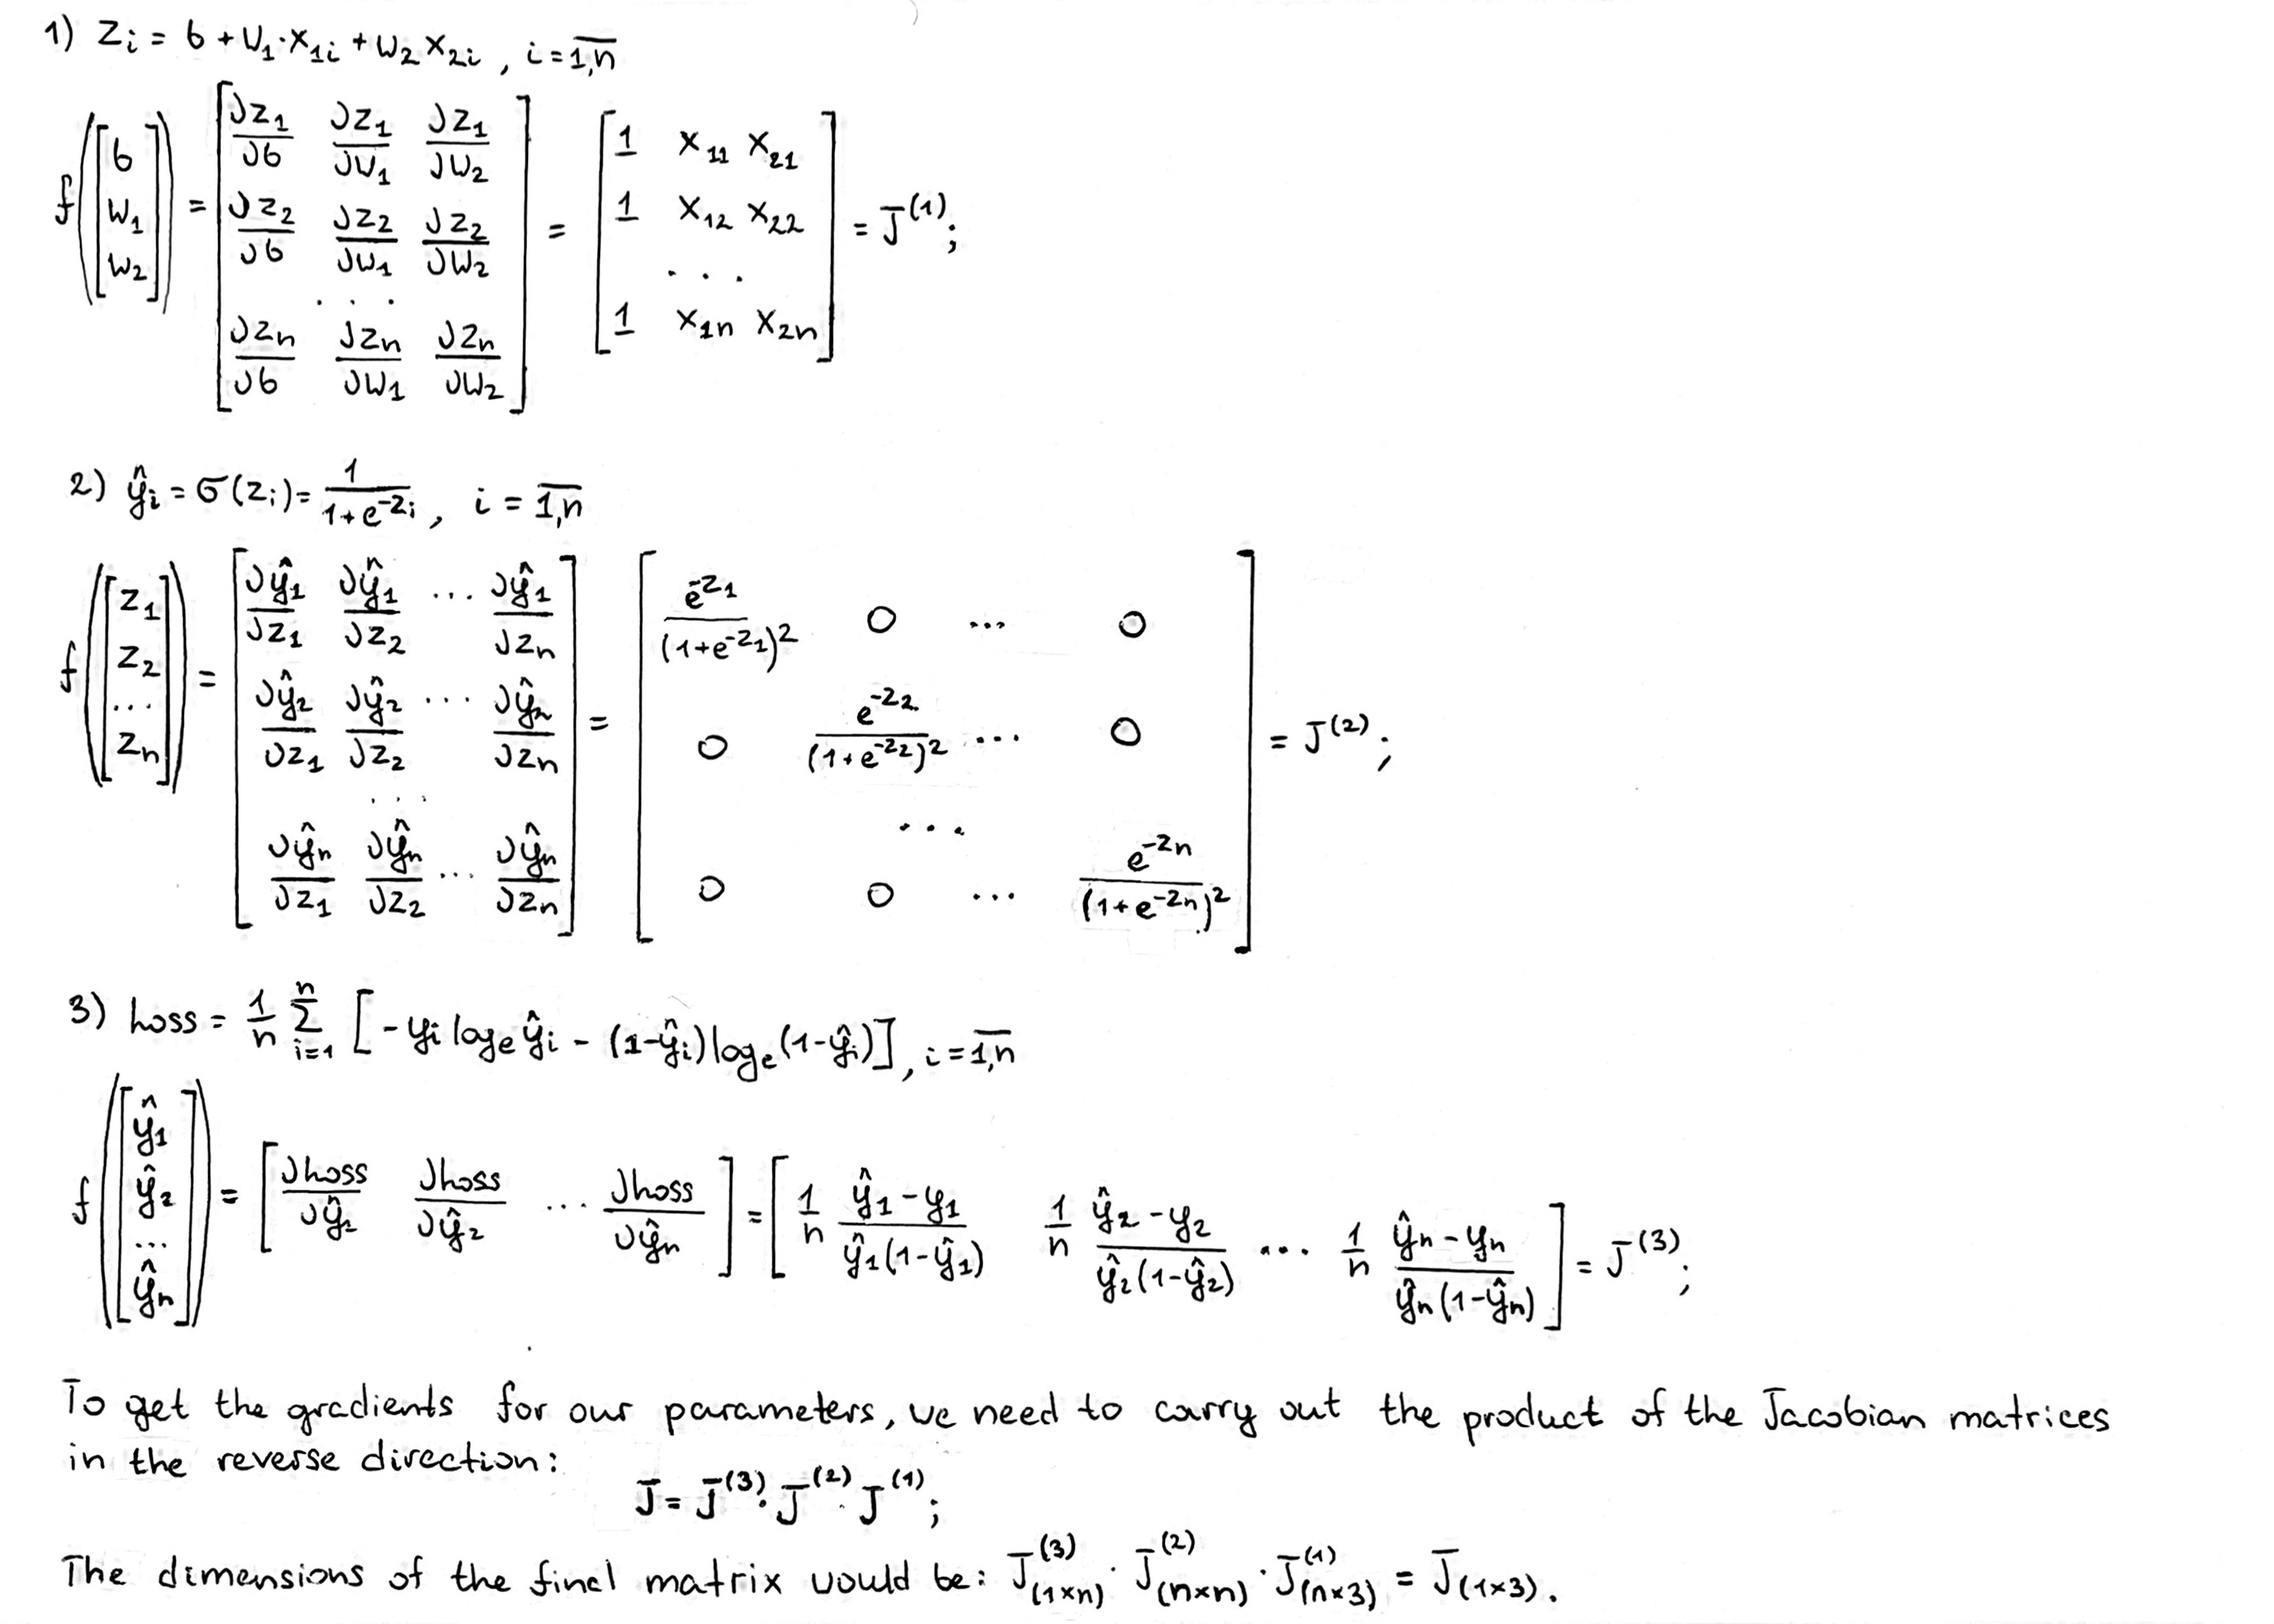

This concept underlies the functions implementing automatic differentiation in the modern frameworks. In the case of Pytorch, back-propagation is done by using the Jacobian-vector product [3]. This approach differs slightly in the way the matrices are multiplied, while the structural elements and the result are remain same. In the next section, we will compare estimates for the computational graph and Jacobian matrices product, represented above, in order to confirm our calculations.

For those who want to learn more about how the Pytorch Autograd Engine works, I have prepared a list of resources that will help you understand the idea behind it [5].



# Gradient finding process

Let's define our tensors:

*   **w** - the weights of logistic regression;
*   **x** - the training set used to estimate the model;
*   **y** - the dependent variable;



In [ ]:
#Note that we set requires_grad=True to let autograd know, with respect to which tensor it has to find the derivatives of the loss.
w = torch.tensor([[0.0], [0.0], [0.0]], dtype=torch.float32, requires_grad=True)
x = x_train_t
y = y_train_t

Before we start doing the calculations, we need to make sure the dimensions of the tensors are correct.

In [ ]:
print(f"shape of w: {w.shape}; x: {x.shape}; y: {y.shape}")

shape of w: torch.Size([3, 1]); x: torch.Size([320, 3]); y: torch.Size([320, 1])


This code replicates the phases from the computational graph sheet, so you can easily track how the results, represented below, are gained.

In [ ]:
#The numbers next to the code correspond to the node operations mentioned in the computational graph;
z = x @ w #(1)
y_hat = torch.sigmoid(z) #(2)
loss = (- y * torch.log(y_hat) - (1 - y) * torch.log(1-y_hat)).mean()  #(3) - custom version of nn.BCELoss()

Here we must say a few words about the inner process. From the moment the tensors are declared, the engine tracks all the operations in which tensor $w$ is taking part. It not only calculates the result of a particular operation, but also stores its derivative in the hidden part of the graph [_]. After the forward pass is done, we could perform the back-propagation by running the backward() command. It will execute the calculations in the hidden graph and compute the gradient. We can access it via the ".grad" attribute.

In [ ]:
# gradient calculation with respect to the graph leaves.
loss.backward()

In [ ]:
w.grad

tensor([[ 0.0063],
        [-0.1846],
        [-0.2508]])

We can also express these values using the formulas we derived earlier:

In [ ]:
with torch.no_grad():
  dw0 = (x[:,0].reshape(-1, 1) * (y_hat-y)).mean()
  dw1 = (x[:,1].reshape(-1, 1) * (y_hat-y)).mean()
  dw2 = (x[:,2].reshape(-1, 1) * (y_hat-y)).mean()

In [ ]:
print(f"dw0: {dw0}; dw1: {dw1}; dw2: {dw2};")

dw0: 0.0062500000931322575; dw1: -0.18456122279167175; dw2: -0.2507587969303131;


As we can see, the results match, which confimns the calulations outlined in the theoretical block.

# Learning rate & parameters optimization

To adjust our weights, we need to subtract the gradient from the $w$ tensor. In practice, we rarely use the entire magnitude of the gradient components for this purpose, but rather some part of them. That is why we need to define the tuning parameter that will determinte the magninute of step (update) each iteration. In the field of machine learning, it is also known as **learning rate**.

**High learning rate** allows the model to learn faster. Theoretically, this allows us to reach the global minimum in fewer iterations. But it is not always the case. When the steps are too large, it can interfere with convergence at the optimum point and lead to overshoot.

While **low learning rate** suggests a more optimal way to train the model, but significantly increases the number of iterations. The problem we might run into here is that in light of previous data transformations, an excessive number of iterations may be required due to tiny weight updates. In some cases, 20.000 - 30.000 epochs doesn't work.

In this section, we will examine it’s affect on the parameter optimisation process by tracking the history of the cost function estimates for different rates. This will clearly demonstrate us the role of learning rate in the model training.

Let`s start by using the **automated solution** first. This step is justified by the need to compare our results.

In [ ]:
#Note that regularization is applied by default; To remove it, we need to set: penalty='none'
model = LogisticRegression(penalty='none', max_iter = 4000, solver='newton-cg').fit(x_train[:,[1,2]], y_train.reshape(-1))

In [ ]:
print(f"Estimated coefficients: intercept {model.intercept_}; w1 {model.coef_[:,0]}; w2 {model.coef_[:,1]}")

Estimated coefficients: intercept [-0.06878692]; w1 [1.14345041]; w2 [1.58352602]


Now let's **put your approach into practice**. To do this, we need redefine our variables, put the optimization algorithm inside the loop and wrap it all in a custom function. The last step is optional, but since we want to test different learning rates, it seems reasonable to avoid code duplication. That is why the optimization block was implemented in this way.

In [ ]:
w = torch.tensor([[0.0], [0.0], [0.0]], dtype=torch.float32, requires_grad=True)
x = x_train_t
y = y_train_t

In [ ]:
lr = 0.1 #learning rate
cost_f = np.array([]) #array to collect cost function values

In [ ]:
def model_training(w, x, y, lr, cost_f, num_iter = 4000):

  for epoch in range(num_iter):
    z = x @ w
    y_hat = torch.sigmoid(z)
    loss = (- y * torch.log(y_hat) - (1 - y) * torch.log(1-y_hat)).mean()

    loss.backward()

    with torch.no_grad():
      #weights update;
      w -=  lr * w.grad
      #collection of the loss function estimates;
      cost_f = np.append(cost_f, loss)

    #empty the gradients to provide the next iterantion step
    w.grad.zero_()

  return cost_f, w

In [ ]:
#solution
cost_f, w = model_training(w, x, y, lr, cost_f)

In [ ]:
w

tensor([[-0.0688],
        [ 1.1434],
        [ 1.5835]], requires_grad=True)

There is a huge variety of optimization algorithms that can be used to find parameters. Some of them are more powerful in comparison with a Stochastic gradient descent and may overcome the most typial problems, like local minimums, saddle points, etc. By comparing the estimates with a Newton`s method, we want to ensure that they were obtained as a result of convergence in the the global minimum. In other words, this is a kind of cross-check to confirm our scores.

In accordance with the given results, we can say that optimization was performed successfully. The weight matrices of both models contain the same values. We also may visualize the process of training by plotting the collected estimates of the cost function.

In [ ]:
style.use('ggplot')

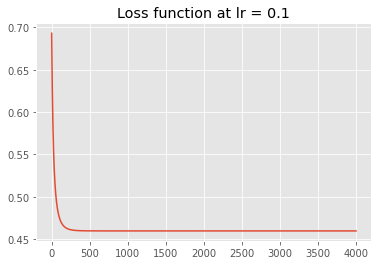

In [ ]:
plt.title("Loss function at lr = 0.1")
plt.plot(cost_f)

As is evident from the plot, the loss decreased significantly in the first 200 iterations. Than it continues the reduction, but the scale of change becames tiny. That is why the rest part of plot resembles an elongated horizontal line (which is not indeed). The **update will be performed until the moment**, we reach the global minimum or will be such close to it, that the gradient multiplied by the learning rate will give almost no result.

Now, let`s change the value of the learning rate to 0.01 and perform the same operation.

In [ ]:
w = torch.tensor([[0.0], [0.0], [0.0]], dtype=torch.float32, requires_grad=True)
x = x_train_t
y = y_train_t

In [ ]:
lr = 0.01 #learning rate
cost_f = np.array([]) #array to collect cost function values

In [ ]:
cost_f, w = model_training(w, x, y, lr, cost_f)

In [ ]:
#estimated coefficients
print(w)

tensor([[-0.0637],
        [ 1.1011],
        [ 1.5250]], requires_grad=True)


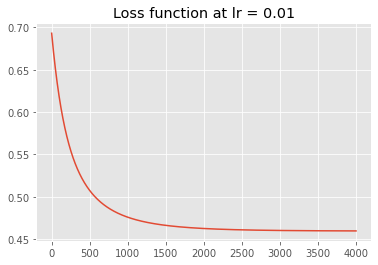

In [ ]:
plt.title("Loss function at lr = 0.01")
plt.plot(cost_f)

The slope is smoother, which is explained by the size of the steps. There is no longer a "straight line" on the horizontal axis. Moreover, according to the  weights estimates - the coefficients were not fully optimized. This is the case, we described in the theoretical section above.

**But what is the reason?**

Despite the fact that we changed learning rate from 0.1 to 0.01, we also have to remember, that we rescaled the original data at the beginning. If the influence of this factor is not obvious in current representation, let us recall the formulas we derived earlier:

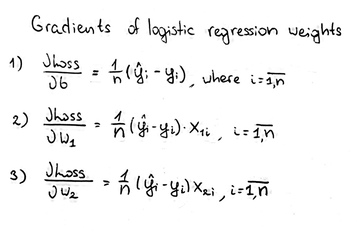

Using scaling techniques, we can significantly change the magnitude of the values in our dataset. This, in turn, will lead to smaller estimates of partial derivatives, outlined above. By taking a percent of their magnitute (learning rate = 0.01), the weights update becomes tiny. That's why after 4000 interactions we still haven't reached our goal.

# Classical way of model construction

**We have already finished the main part** of logistic regression optimization using the neural networks approach. Up to this point, we have tried to avoid automatic functions where possible to provide an intuitive understanding of how models are trained. But in practice, we will rather refer to well-known packages and their functionality than to write all these commands and formulas by hand.

Thus, this section is dedicated to **classical way of model construction** in python.

In [ ]:
x = x_train_t[:,[1,2]]
y = y_train_t

In [ ]:
class LogisticReg(nn.Module):
  def __init__(self, n_features_f):
    super(LogisticReg, self).__init__()
    self.linear = nn.Linear(n_features_f, 1)

    with torch.no_grad():
        self.linear.weight.copy_(torch.zeros(1))
        self.linear.bias.copy_(torch.zeros(1))

  def forward(self, x):
    y_pred = torch.sigmoid(self.linear(x))
    return(y_pred)

In [ ]:
n_features = x.shape[1]

In [ ]:
#creation of an instance of a class "LogisticReg";
model = LogisticReg(n_features)

#create loss and optimizer:
loss = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [ ]:
for epoch in range(4000):
  #forward pass;
  y_hat = model.forward(x)
  
  #compute the loss and perform backpropagation;
  Loss = loss(y_hat, y).backward()

  #updates;
  optimizer.step()

  #empty gradients;
  optimizer.zero_grad()

In [ ]:
#let`s derive the estimated coefficients and represent them in a more convenient way;
coef_m = torch.hstack((model.linear.bias.reshape(-1,1), model.linear.weight)).detach()
print(coef_m)

tensor([[-0.0688,  1.1434,  1.5835]])


# Optimal threshold & decision boundary

Since the model is trained, we can estimate the optimal threshold that will allow us to classify the probabilities. This step is often overlooked due to a superficial understanding of the underlying process. In accordance with covered theory, there is no evident reason to consider 0.5 as an optimal one. Ignorance of this fact can significantly reduce the model performance, even if the training itself was performed well. That is why, before comparing the predictions for the training and test sets, we need to specify the optimal threshold that will maximize the accuracy.

Here, we will not go into the details of confusion matrices, ROC curves, and related terminology — this is beyond the scope of this chapter. But for those, who want to know more, it will be extremely helpful to explore the idea behind them.

In [ ]:
#predictions calculation for the training set;
y_hat = model.forward(x_train_t[:,[1,2]]).detach()
#components of the ROC curve;
fpr, tpr, threshold = metrics.roc_curve(y,  y_hat)

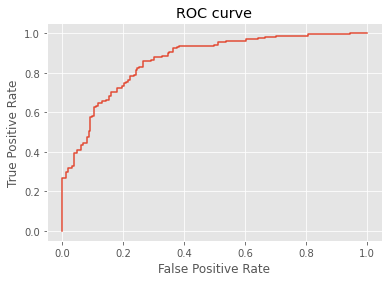

In [ ]:
plt.title("ROC curve")
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

On this graph, we are interested in the value that lies as close as possible to the upper left corner. Note that there is no single way to determine the optimal threshold. Depending on which parameter we want to maximize, we can choose a specific one among the variety of methods. The most general approach is to use the **Youden's J-statistic**, the implementation of which is given below:

In [ ]:
idx = np.argmax(tpr - fpr)
opt_p = threshold[idx]
print(f'The optimal threshold is {opt_p}')

The optimal threshold is 0.4146195650100708


The idea behind the model training lies in its ability to reproduce results similar to those it was trained on. If the model does not correspond to this principle, then there is no practical sense in its usage. Thus,  we want the accuracy rates to be relatively similar. Otherwise, we need to determine the factors that may affect the difference in results. Among the most likely ones could be overfitting, structural issues in the original dataset, data processing aspects, etc.

In [ ]:
def accuracy_cust(x_f, y_f, opt_f):

  #probabilities calculations;
  y_hat = model.forward(x_f).detach()

  #round them with respect to optimal threshold;
  y_hat = torch.round((y_hat - opt_f + 0.5))

  #accuracy computation;
  return metrics.accuracy_score(y_f, y_hats)

In [ ]:
accuracy_cust(x_train_t[:, [1,2]], y_train_t, opt_p)

0.79375

In [ ]:
accuracy_cust(x_test_t[:, [1,2]], y_test_t, opt_p)

0.8125

As we can see, the results met our expectations: the model's accuracy is 79% and 81% for the training and test sets, respectively. Obviously, from a practical point of view, these estimates are far from ideal. But in this case, we are more interested in their relationship between them than in the estimates themselves.

In this article we covered the background of the neural network training on the example of logistic regression. In the light of simplicity some parts of the analysis like regularization and certain aspects of data processing were ignored. By doing so, we left the basics and delved into calculations underlying the optimization process. The scaling technique accelerated the convergence process, but did not change the internal dependencies between variables. Thus, to improve accuracy, we need to implement the missing parts of the analysis. This example clearly demonstrates us the role of each stage and its impact on the final result.

Knowing the optimal threshold, we can also visualize the classification process through the **decision boundary**. Due to the fact that the number of factors determines the space we are working with, the decision boundary can be displayed as a line in two-dimensional space that divides our data into two classes. To do this, we need to substitute the value of the optimal threshold ($p$) into the general equation and express one of the variables as shown below:

\begin{gather}
ln(\frac{p}{1-p}) = w_{1}x_{1i} + w_{2}x_{2i} + b \newline 
\newline
x_{2i} = - \frac{w_{1}}{w_{2}}x_{1i} - \frac{b}{w_{2}} + \frac{1}{w_{2}}ln(\frac{p}{1-p})
\end{gather}

For the sake of transparency, we will visualize the decision boundaries for both: optional and default thresholds.

In [ ]:
X = np.vstack((x_train, x_test))
Y = np.vstack((y_train, y_test))

In [ ]:
x1 = np.arange(np.min(X[:, 1]), np.max(X[:, 1]))

In [ ]:
b, w1, w2 = coef_m[0, 0], coef_m[0, 1], coef_m[0, 2]

In [ ]:
#decision boudary for default threshold - 0.5;
x2_def = - w1/w2 * x1 - b/w2

#decision boudary for optimal threshold - 0.4146;
x2_opt = - w1/w2 * x1 - b/w2 + np.log(opt_p/(1-opt_p))/w2

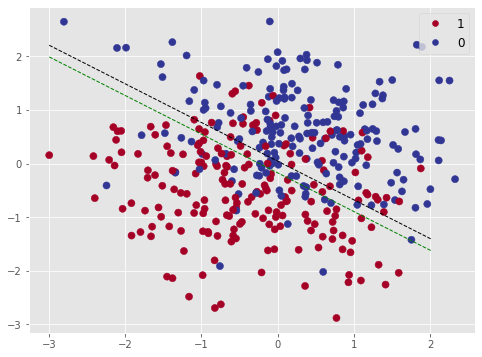

In [ ]:
plt.figure(figsize=(8,6))
scatter=plt.scatter(X[:, 1], X[:, 2], s=50, c=Y, cmap='RdYlBu')
plt.legend(handles=scatter.legend_elements()[0], labels=['1','0'], loc='upper right', fontsize=12)
plt.plot(x1, x2_def, 'k', lw=1, ls='--')
plt.plot(x1, x2_opt, 'k', lw=1, ls='--', color='#008000')
plt.show()

As we can see, there is a noticeable difference in the lines position on the chart. The green line represents the decision boundary for the optimal threshold, whereas the black line relates to the default one. Due to the fact that our data is a little messy, it is visually difficult to make a choice in favor of one of them. But, knowing the above results, we can state that the green line provides the bigger number of correct classifications.

Let's assume that we are dealing with other data where the boundary between classes is clearly visible. If the true value of the optimal threshold is far from the default one, despite how well the previous steps were performed, using 0.5 for classification purposes will result in a significant reduction in model performance. That is why we should pay special attention to each stage of the analysis.

# Summary

At was mentioned at the beginning, the purpose of this chaptes is to cover the idea behind neural networks training. We started from the theory block, which formed the basic intuition of the process inside. On its basis, we also rebuilt the logistic model, avoiding automated software where possible. As we delved deeper into the topic, we improved the code and identified the main factors that can affect the effectiveness of stochastic gradient descent optimization. We showed in practice the importance of the data scaling and the learning rate, revealed the concept of a computational graph and the product of Jacobian matrices.

Closer to the end of the chapter, we recreated the model for the third time, using the classical way of model construction in python. The prevoius examples were rather a learning material, than a models themselves. Upon completion of the optimization stage, our results matched the estimates of the proposed automated solution.

Despite the fact, that the further analysis is beyond the scope of this article, we also covered the importance of optimal threshold and the decision boundary in the context of logistic regression. This allowed us to demostate the role of each step of analysis and their impact on the model performance.

**References**

1. Calculus on Computational Graphs: Backpropagation., URL: https://bit.ly/3z8BMLO
2. The Jacobian Matrix: Introducing Vector Calculus., URL: https://bit.ly/3PfcmSm

3. TORCH.AUTOGRAD.BACKWARD description, URL: https://bit.ly/3ODeAdb 

3.1 Overview of PyTorch Autograd Engine, June 08 2021, URL: https://bit.ly/3PZpxqm